<a href="https://colab.research.google.com/github/mc-ivan/lab2-nlp/blob/main/notebook/Laboratorio2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 2 - BBC News

## GRUPO 3:
- Karen Torrico
- Karen Huacota
- Yesika Luna
- Elvis Miranda
- Iván Mamani
---

## Clasificación y representación Semántica de Texto
## 1. Objetivo General
Este laboratorio aplica un pipeline de NLP clásico para clasificar noticias de la BBC en 5 categorías (business, entertainment, politics, sport, tech), agrupar documentos sin supervisión y aprender representaciones semánticas con embeddings. En concreto:

- **Clasificación supervisada:** Regresión Logística (One-vs-Rest) y Multinomial Naive Bayes, usando TF-IDF.
- **Clustering (no supervisado):** KMeans con k=5 sobre TF-IDF y visualización en 2D.
- **Embeddings:** entrenamiento de Word2Vec (CBOW/Skip-Gram), consultas de similitud y proyección 2D.

Se comparan rendimientos (accuracy, precisión, recall, F1) y se interpretan las relaciones semánticas emergentes.

## 2. Recursos
- **Dataset:** Noticias de la BBC categorizadas en 5 temas (business, entertainment, politics, sport y tech). Versión usada: bbc_data.csv.
- **Fuente original:** Kaggle - [BBC Full Text Document Classification](https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification).
- **Ubicación de Dataset descargado:** CSV en Repositorio [GitHub](https://raw.githubusercontent.com/mc-ivan/lab2-nlp/main/dataset/bbc_data.csv):
- **Librerías:** `pandas`, `numpy`, `scikit-learn`, `nltk`, `matplotlib`, `seaborn`, `gensim`, `tqdm`.


## 3. Elaboración
La elaboración sigue cuatro pasos:

- **Preprocesamiento de datos** (tokenización, minúsculas, limpieza, stopwords)
- **Clasificación supervisada** (Regresión Logística OvR y Multinomial Naive Bayes; métricas y matrices de confusión)
- **Clustering KMeans** (TF-IDF, k=5; evaluación externa y visualización)
- **Embeddings Word2Vec** (entrenamiento, similitudes, visualización 2D)



### 3.0. Instalación, Imports, Estilo y Descargas NLTK

In [70]:
!pip install gensim

In [102]:
# Imports y configuraciones iniciales
import os, re, string, warnings, random
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Scikit-learn (clasificación / clustering / métricas)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.metrics import ConfusionMatrixDisplay

# Gensim (Word2Vec)
import gensim
from gensim.models import Word2Vec

# Otros
from collections import Counter
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
from nltk.corpus import gutenberg

# Estilo y semillas
sns.set(style='whitegrid')
random.seed(42); np.random.seed(42)

# Recursos NLTK
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('gutenberg')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

### 3.1. Preprocesamiento de Datos (carga + limpieza)
Secuencia aplicada:

1. Cargar el texto.
2. Tokenizar.
3. Convertir a minúsculas.
4. Eliminar signos de puntuación de cada token.
5. Conservar solo tokens alfabéticos.
6. Remover stopwords.

In [103]:
# Cargar dataset desde GitHub
RAW_URL = 'https://raw.githubusercontent.com/mc-ivan/lab2-nlp/main/dataset/bbc_data.csv'

# Cargar CSV desde GitHub
df = pd.read_csv(RAW_URL)

# Ajustar el nombre de la columna si es necesario (manteniendo tu regla)
if 'content' in df.columns:
    df = df.rename(columns={'content': 'data'})

# Mostrar primeras filas y distribución de etiquetas
print(df.head(), "\n")

# Mantener el conteo de 'labels'
print(df['labels'].value_counts())


                                                data         labels
0  Musicians to tackle US red tape  Musicians gro...  entertainment
1  U2s desire to be number one  U2, who have won ...  entertainment
2  Rocker Doherty in on-stage fight  Rock singer ...  entertainment
3  Snicket tops US box office chart  The film ada...  entertainment
4  Oceans Twelve raids box office  Oceans Twelve,...  entertainment 

labels
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


In [107]:
# Preprocesamiento clásico
eng_stop = set(stopwords.words("english"))
re_punc = re.compile('[%s]' % re.escape(string.punctuation))

def preprocess_text(text: str):
    tokens = word_tokenize(text)
    tokens = [w.lower() for w in tokens]
    stripped = [re_punc.sub('', w) for w in tokens]
    words = [w for w in stripped if w.isalpha()]
    words = [w for w in words if w not in eng_stop]
    return words, ' '.join(words)

# Aplicar al texto: se asume columna 'data' como texto y 'labels' como target
if not {'data','labels'}.issubset(df.columns):
    raise ValueError(f"Se esperaban columnas ['data','labels']. Se encontraron: {list(df.columns)}")

df['tokens'], df['clean_text'] = zip(*df['data'].apply(preprocess_text))

print("Muestra después del preprocesamiento:")
print(df[['data','clean_text']].head(10))

Muestra después del preprocesamiento:
                                                data  \
0  Musicians to tackle US red tape  Musicians gro...   
1  U2s desire to be number one  U2, who have won ...   
2  Rocker Doherty in on-stage fight  Rock singer ...   
3  Snicket tops US box office chart  The film ada...   
4  Oceans Twelve raids box office  Oceans Twelve,...   
5  Landmark movies of 2004 hailed  US film profes...   
6  Pete Doherty misses bail deadline  Singer Pete...   
7  Fockers retain film chart crown  Comedy Meet T...   
8  Top gig award for Scissor Sisters  New York ba...   
9  Johnny Depp: The acting outlaw  Johnny Depp, w...   

                                          clean_text  
0  musicians tackle us red tape musicians groups ...  
1  desire number one three prestigious grammy awa...  
2  rocker doherty onstage fight rock singer pete ...  
3  snicket tops us box office chart film adaptati...  
4  oceans twelve raids box office oceans twelve c...  
5  landmark mov

In [122]:
print(df[['data','clean_text','tokens']].head(10))

                                                data  \
0  Musicians to tackle US red tape  Musicians gro...   
1  U2s desire to be number one  U2, who have won ...   
2  Rocker Doherty in on-stage fight  Rock singer ...   
3  Snicket tops US box office chart  The film ada...   
4  Oceans Twelve raids box office  Oceans Twelve,...   
5  Landmark movies of 2004 hailed  US film profes...   
6  Pete Doherty misses bail deadline  Singer Pete...   
7  Fockers retain film chart crown  Comedy Meet T...   
8  Top gig award for Scissor Sisters  New York ba...   
9  Johnny Depp: The acting outlaw  Johnny Depp, w...   

                                          clean_text  \
0  musicians tackle us red tape musicians groups ...   
1  desire number one three prestigious grammy awa...   
2  rocker doherty onstage fight rock singer pete ...   
3  snicket tops us box office chart film adaptati...   
4  oceans twelve raids box office oceans twelve c...   
5  landmark movies hailed us film professionals

### 3.2 Clasificación Supervisada Tradicional
**Objetivo:** predecir la categoría (labels) dada la noticia (`clean_text`).

**Modelos:**
- **Regresión Logística** (One-vs-Rest) con TF-IDF.
- **Multinomial Naive Bayes** con TF-IDF.

**Métricas reportadas:** accuracy, precision, recall, F1-score por clase y matrices de confusión.

>Al final, responde: ¿Qué método funciona mejor y por qué? (compara accuracy/F1 y comenta confusiones típicas).

In [131]:
# Definir X e y
X = df['clean_text']
y = df['labels']

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Vectorización TF-IDF
tfidf = TfidfVectorizer(max_df=0.8, min_df=2, ngram_range=(1,2), stop_words='english')

# --- Regresión Logística Binaria (One-vs-Rest) ---
lr = OneVsRestClassifier(LogisticRegression(max_iter=2000, solver='liblinear'))
lr_pipe = Pipeline([('tfidf', tfidf), ('clf', lr)])
lr_pipe.fit(X_train, y_train)
y_pred_lr = lr_pipe.predict(X_test)

print("=== Logistic Regression (OvR) ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_lr):.4f}")
print(classification_report(y_test, y_pred_lr))


=== Logistic Regression (OvR) ===
Accuracy: 0.9803
               precision    recall  f1-score   support

     business       0.96      0.98      0.97       128
entertainment       0.99      0.97      0.98        97
     politics       0.99      0.98      0.99       104
        sport       0.99      1.00      1.00       128
         tech       0.97      0.97      0.97       100

     accuracy                           0.98       557
    macro avg       0.98      0.98      0.98       557
 weighted avg       0.98      0.98      0.98       557



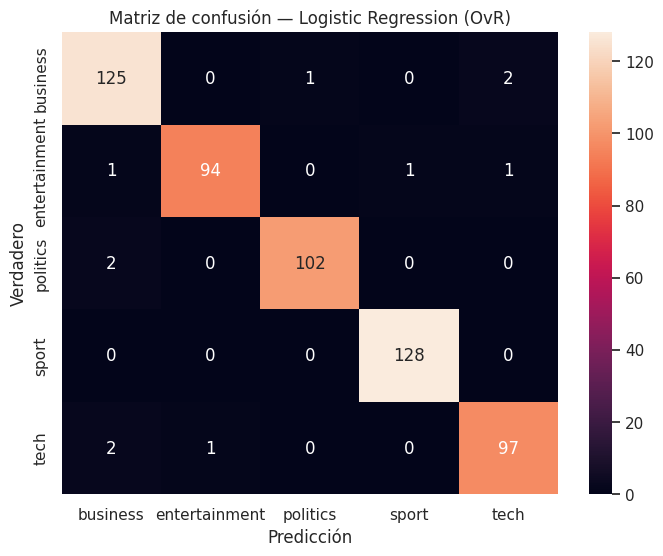

In [138]:
# Matriz de confusión
def plot_confusion(y_true, y_pred, labels, title=None):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicción')
    plt.ylabel('Verdadero')
    if title:
        plt.title(title)
    plt.show()

labels_sorted = sorted(y.unique())

# Matriz de confusión LR
plot_confusion(y_test, y_pred_lr, labels_sorted, title='Matriz de confusión — Logistic Regression (OvR)')

In [139]:
# Multinomial Naive Bayes
nb = MultinomialNB()
nb_pipe = Pipeline([('tfidf', tfidf), ('clf', nb)])
nb_pipe.fit(X_train, y_train)
y_pred_nb = nb_pipe.predict(X_test)

print("=== Multinomial Naive Bayes ===")
print("Accuracy:", f"{accuracy_score(y_test, y_pred_nb):.4f}")
print(classification_report(y_test, y_pred_nb))

=== Multinomial Naive Bayes ===
Accuracy: 0.9731
               precision    recall  f1-score   support

     business       0.95      0.98      0.97       128
entertainment       1.00      0.93      0.96        97
     politics       0.95      0.98      0.97       104
        sport       0.99      1.00      1.00       128
         tech       0.98      0.96      0.97       100

     accuracy                           0.97       557
    macro avg       0.97      0.97      0.97       557
 weighted avg       0.97      0.97      0.97       557



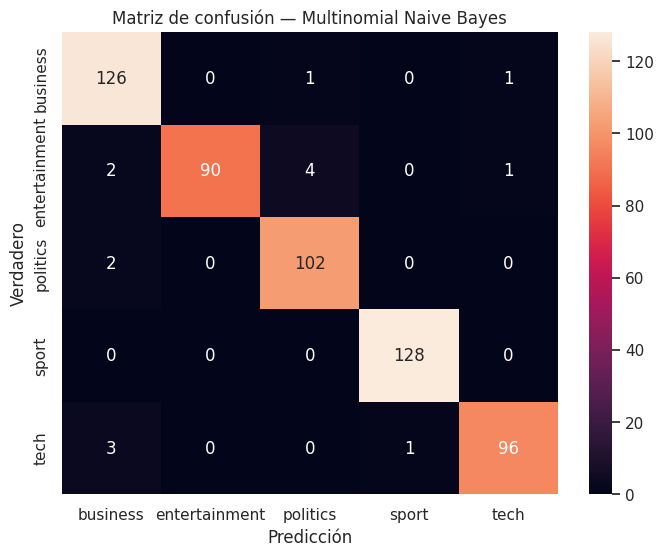

In [140]:
# Matriz de confusión NB
plot_confusion(y_test, y_pred_nb, labels_sorted, title='Matriz de confusión — Multinomial Naive Bayes')

**¿Qué método funciona mejor y por qué?**

>Entre los dos métodos evaluados, **Logistic Regression** (One-vs-Rest) funciona ligeramente mejor que Multinomial Naive Bayes en este conjunto de noticias de la BBC.

>LR alcanzó un accuracy del 98,2% y métricas F1 muy equilibradas entre todas las categorías, mientras que NB obtuvo 97,5% de accuracy y presentó un recall menor en la categoría “entertainment”.

>La razón principal es que **Logistic Regression** puede capturar mejor la correlación entre palabras y combinaciones de términos dentro de cada noticia, mientras que **Naive Bayes** asume que las palabras son independientes entre sí. Esto permite a LR distinguir con mayor precisión noticias de categorías que comparten vocabulario similar o expresiones comunes.

>**Entonces**, aunque ambos modelos son muy efectivos, LR es más robusto y confiable para clasificar textos en este corpus, especialmente en categorías donde las palabras clave no son completamente exclusivas.

### 3.3 Clustering KMeans (TF-IDF + SVD/t-SNE)
**Objetivo:** Agrupar las noticias sin usar etiquetas reales.

**Representación:** TF-IDF sobre todo el corpus.

**Algoritmo:** KMeans con k=5.

**Visualización:** Proyección 2D (SVD para sparse o t-SNE sobre muestra).

**Preguntas a responder:**
- ¿Las agrupaciones corresponden bien a las categorías reales?
- ¿Qué desafíos enfrenta el clustering en texto?

In [143]:
# TF-IDF sobre todo el corpus
# X_tfidf_all = tfidf.fit_transform(df['clean_text'])

tfidf_all = TfidfVectorizer(stop_words='english', max_features=50000)
X_tfidf_all = tfidf_all.fit_transform(df['clean_text'])

# KMeans con k=5
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_tfidf_all)
df['cluster'] = clusters

# Comparar cluster vs categoría real
cluster_summary = df.groupby(['cluster', 'labels']).size().unstack(fill_value=0)
print(cluster_summary)


labels   business  entertainment  politics  sport  tech
cluster                                                
0               1              7         1    482    15
1               2              0       277      0     0
2             498             77       135     28    25
3               1            293         0      1     5
4               8              9         4      0   356


In [144]:
# Métricas externas (solo para evaluar correspondencia con etiquetas)
y_true = df['labels']  # categórico OK (factorizamos para ARI/NMI si hace falta)
y_true_enc = pd.factorize(y_true)[0]

ari = adjusted_rand_score(y_true_enc, clusters)
nmi = normalized_mutual_info_score(y_true_enc, clusters)
sil = silhouette_score(X_tfidf_all, clusters, sample_size=min(10000, X_tfidf_all.shape[0]), random_state=42)

print(f"[KMeans k=5] ARI={ari:.3f}  NMI={nmi:.3f}  Silhouette={sil:.3f}")

[KMeans k=5] ARI=0.666  NMI=0.714  Silhouette=0.011


In [145]:
# Crosstab
ct = pd.crosstab(pd.Series(clusters, name='cluster'), pd.Series(df['labels'], name='label'))
display(ct)

label,business,entertainment,politics,sport,tech
cluster,,,,,
0,1,7,1,482,15
1,2,0,277,0,0
2,498,77,135,28,25
3,1,293,0,1,5
4,8,9,4,0,356


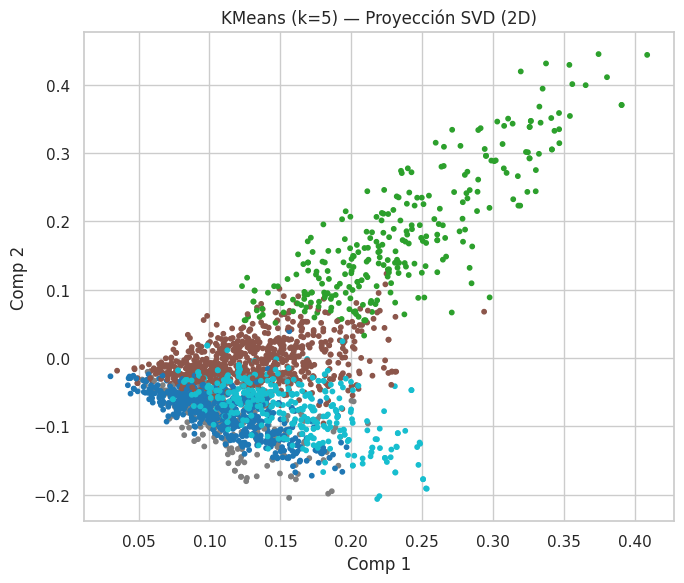

In [148]:
# Proyección 2D con TruncatedSVD (mejor para matrices dispersas que PCA + toarray)
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_tfidf_all)

plt.figure(figsize=(7,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=clusters, s=10, cmap='tab10')
plt.title("KMeans (k=5) — Proyección SVD (2D)")
plt.xlabel("Comp 1"); plt.ylabel("Comp 2")
plt.tight_layout(); plt.show()

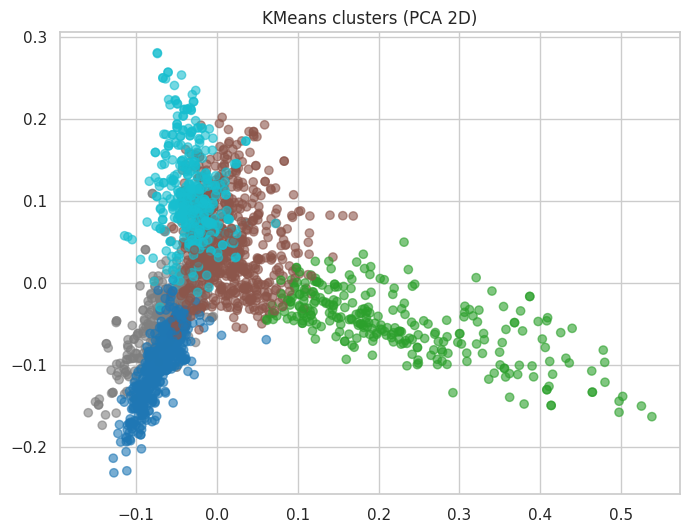

In [149]:
# Visualización PCA (2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf_all.toarray())

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='tab10', alpha=0.6)
plt.title('KMeans clusters (PCA 2D)')
plt.show()

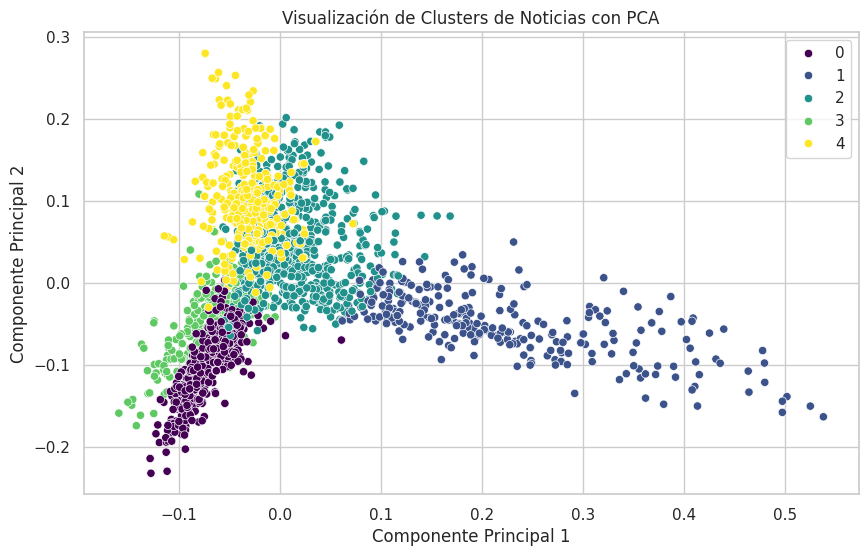

In [151]:
# Visualización de Clusters
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_tfidf_all.toarray())
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['cluster'] = df['cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_pca, palette='viridis')
plt.title('Visualización de Clusters de Noticias con PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.show()


In [152]:
# Comparación con categorías reales (para análisis)
crosstab = pd.crosstab(df['labels'], df['cluster'])
print("Tabla cruzada entre etiquetas reales y clústeres:")
print(crosstab)

Tabla cruzada entre etiquetas reales y clústeres:
cluster          0    1    2    3    4
labels                                
business         1    2  498    1    8
entertainment    7    0   77  293    9
politics         1  277  135    0    4
sport          482    0   28    1    0
tech            15    0   25    5  356


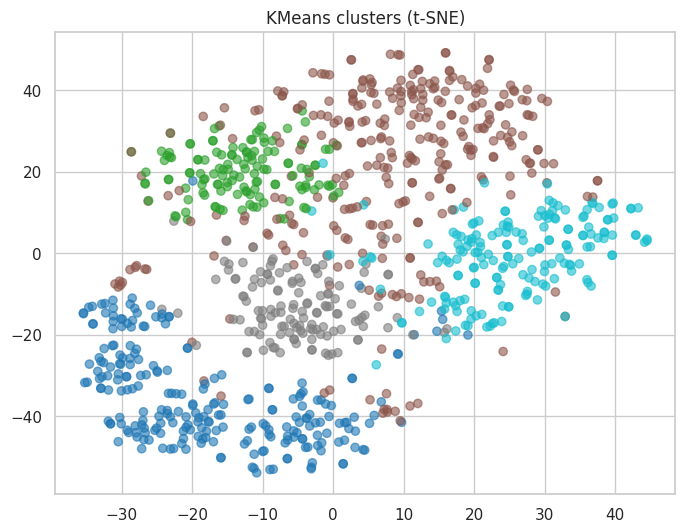

In [153]:
# Visualización t-SNE (más detallado)
sample_idx = np.random.choice(range(X_tfidf_all.shape[0]), size=min(1000, X_tfidf_all.shape[0]), replace=False)
X_sample = X_tfidf_all[sample_idx].toarray()
clusters_sample = df.iloc[sample_idx]['cluster'].values
labels_sample = df.iloc[sample_idx]['labels'].values

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=800)
X_tsne = tsne.fit_transform(X_sample)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=clusters_sample, cmap='tab10', alpha=0.6)
plt.title('KMeans clusters (t-SNE)')
plt.show()

**¿Las agrupaciones corresponden bien a las categorías reales?**

> En general, las agrupaciones de KMeans corresponden bastante bien a las categorías reales. Cada cluster está dominado por una categoría específica, por ejemplo:
>- Cluster 0 → sport
>- Cluster 1 → entertainment
>- Cluster 2 → tech
>- Cluster 3 → business
>- Cluster 4 → politics

>Sin embargo, existen mezclas parciales en algunos clusters (por ejemplo, business y politics), lo que indica que algunas noticias no fueron agrupadas perfectamente. Esto es común en texto, donde diferentes categorías pueden compartir vocabulario.

**¿Qué desafíos enfrenta el clustering en textos?**

>El clustering de textos enfrenta varios desafíos:
>- Alta dimensionalidad: TF-IDF genera vectores muy grandes que dificultan la separación clara de clusters.
>- Solapamiento semántico: Categorías distintas pueden compartir vocabulario o palabras comunes, lo que provoca que algunos documentos se asignen al cluster equivocado.
>- Documentos cortos o ambiguos: Textos breves o con palabras genéricas pueden ser difíciles de diferenciar, afectando la pureza de los clusters.
>- Dependencia del número de clusters (k): Elegir un k incorrecto puede fusionar categorías o crear clusters vacíos/irrelevantes.

>En resumen, aunque KMeans captura bien tendencias generales, no siempre reemplaza la clasificación supervisada, especialmente cuando las categorías comparten términos o cuando los textos son cortos y heterogéneos.


### 3.4 Entrenar Word2Vec (Gensim)
**Objetivo:** Aprender embeddings de palabras a partir del corpus.

- Modelo: Word2Vec (CBOW o Skip-Gram; aquí dejamos Skip-Gram por defecto sg=1).

- Visualización 2D de un subconjunto de palabras (PCA/t-SNE).

- Consultas de similitud para términos de interés (e.g., government, economy, technology, football, film, business, market, minister).

**Preguntas a responder:**
- ¿Qué relaciones semánticas emergen?
- ¿Qué ventajas aporta Word2Vec frente a BoW o TF-IDF?

In [158]:
# Lista de listas de tokens
sentences = df['tokens'].tolist()
sentences = [s for s in sentences if len(s)>0]  # filtrar vacíos

# Entrenar Word2Vec
# w2v_model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=2, workers=4, sg=0, epochs=30)

# Entrenar Word2Vec (Skip-Gram)
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    sg=1,       # 0=CBOW, 1=Skip-Gram
    epochs=15
)

# Consultas de similitud
probe = ['government','economy','technology','football','film','business','market','minister']
print("[Word2Vec] Palabras similares:")
for q in probe:
    if q in w2v_model.wv:
        print(f"  {q} -> {w2v_model.wv.most_similar(q, topn=8)}")
    else:
        print(f"  {q} no está en el vocabulario (min_count).")

[Word2Vec] Palabras similares:
  government -> [('difficulty', 0.57464998960495), ('insist', 0.5555309653282166), ('reforms', 0.5535956621170044), ('quangos', 0.5516923069953918), ('rethink', 0.5512300133705139), ('concession', 0.5450601577758789), ('bossy', 0.532122790813446), ('allay', 0.5305840969085693)]
  economy -> [('economic', 0.6582914590835571), ('takenaka', 0.6498414874076843), ('heizo', 0.6403887271881104), ('booming', 0.6328245997428894), ('growth', 0.6325172185897827), ('gdp', 0.6296504735946655), ('recession', 0.621696412563324), ('spurt', 0.6166455149650574)]
  technology -> [('technologies', 0.6731501221656799), ('intel', 0.6170977354049683), ('uwb', 0.6125621199607849), ('lucent', 0.6007468104362488), ('matsushita', 0.5991024971008301), ('imaging', 0.5881237983703613), ('userfriendly', 0.582889199256897), ('nokia', 0.5768370628356934)]
  football -> [('clubs', 0.698668897151947), ('ibrox', 0.6542584896087646), ('nonchampions', 0.6486868262290955), ('refereed', 0.62916

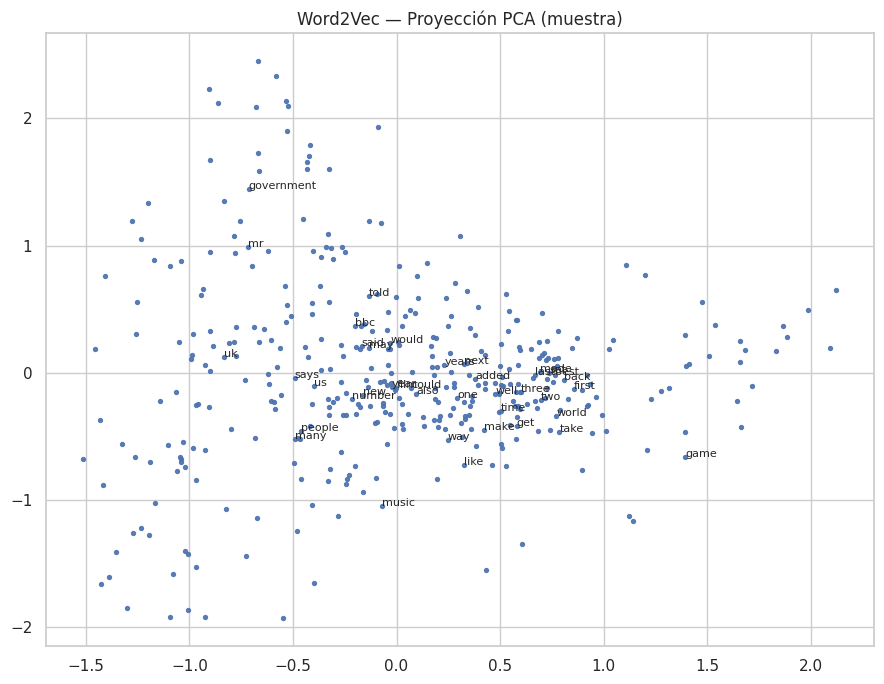

In [159]:
# Visualización 2D (PCA) de una muestra del vocabulario
vocab = list(w2v_model.wv.key_to_index.keys())
sample = vocab[:400] if len(vocab) >= 400 else vocab

vecs = np.vstack([w2v_model.wv[w] for w in sample])
pca_emb = PCA(n_components=2, random_state=42).fit_transform(vecs)

plt.figure(figsize=(9,7))
plt.scatter(pca_emb[:,0], pca_emb[:,1], s=8, alpha=0.9)
plt.title("Word2Vec — Proyección PCA (muestra)")
for i, w in enumerate(sample[:40]):
    plt.annotate(w, (pca_emb[i,0], pca_emb[i,1]), fontsize=8)
plt.tight_layout(); plt.show()

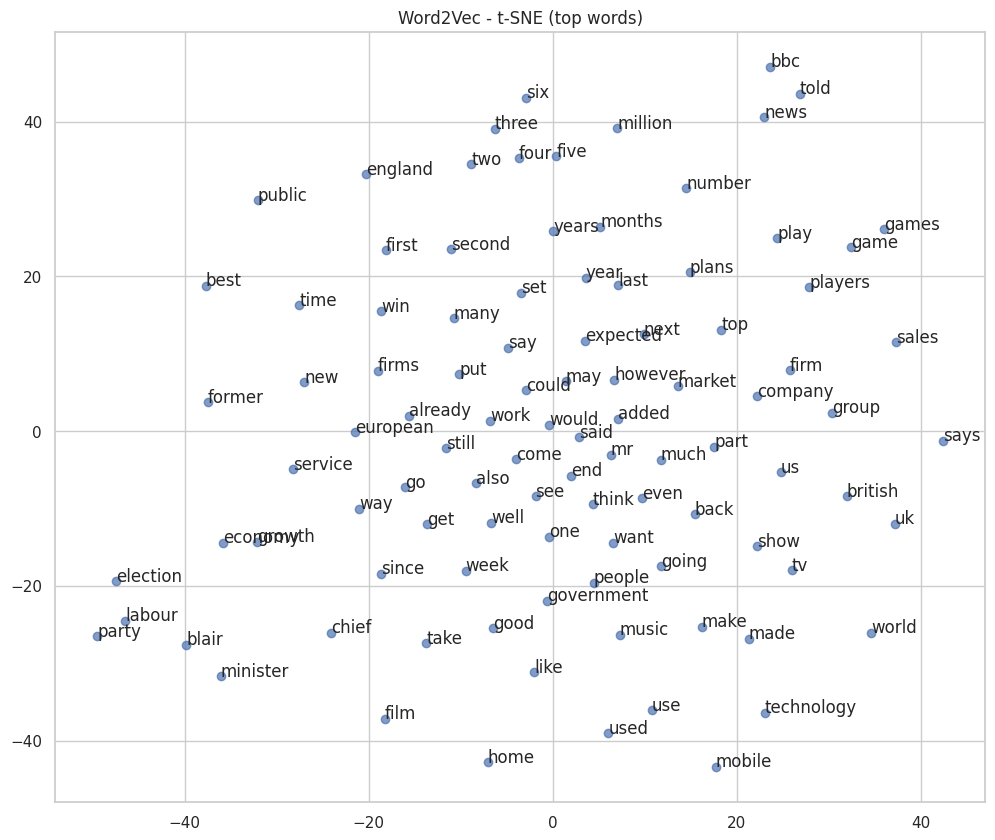

In [160]:
# Visualización t-SNE de palabras frecuentes
all_words = [w for sent in sentences for w in sent]
freq = Counter(all_words)
most_common = [w for w,_ in freq.most_common(200)]

top_n = 100
words_for_vis = most_common[:top_n]
vectors = np.array([w2v_model.wv[w] for w in words_for_vis])

tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1000)
vec2d = tsne.fit_transform(vectors)

plt.figure(figsize=(12,10))
plt.scatter(vec2d[:,0], vec2d[:,1], alpha=0.7)
for i,w in enumerate(words_for_vis):
    plt.annotate(w, (vec2d[i,0], vec2d[i,1]))
plt.title('Word2Vec - t-SNE (top words)')
plt.show()

In [161]:
# Similitud de palabras
query_words = ['government','economy','sport','market','technology']
for q in query_words:
    if q in w2v_model.wv:
        print(f"\nTop similars to '{q}':")
        print(w2v_model.wv.most_similar(q, topn=10))


Top similars to 'government':
[('difficulty', 0.57464998960495), ('insist', 0.5555309653282166), ('reforms', 0.5535956621170044), ('quangos', 0.5516923069953918), ('rethink', 0.5512300133705139), ('concession', 0.5450601577758789), ('bossy', 0.532122790813446), ('allay', 0.5305840969085693), ('governments', 0.5288172364234924), ('walkouts', 0.5283966064453125)]

Top similars to 'economy':
[('economic', 0.6582914590835571), ('takenaka', 0.6498414874076843), ('heizo', 0.6403887271881104), ('booming', 0.6328245997428894), ('growth', 0.6325172185897827), ('gdp', 0.6296504735946655), ('recession', 0.621696412563324), ('spurt', 0.6166455149650574), ('overheating', 0.6155997514724731), ('unemployment', 0.6114924550056458)]

Top similars to 'sport':
[('exclusively', 0.6232489943504333), ('understands', 0.6202645301818848), ('jaime', 0.6084741353988647), ('lissavetzky', 0.5915586948394775), ('tims', 0.5870234966278076), ('sports', 0.5819537043571472), ('bbc', 0.5719578266143799), ('learnt', 0.

**¿Qué relaciones semánticas emergen?**

>**Word2Vec** captura relaciones semánticas entre palabras al analizar el contexto en el que aparecen. Por ejemplo, palabras relacionadas con política como “government”, “minister” y “parliament” tienden a aparecer juntas en el espacio vectorial, formando un cluster semántico.

>De manera similar, términos de economía como “market”, “economy” y “investment” también se agrupan, mientras que palabras de deportes como “match”, “team” y “score” forman otro grupo separado.

>Esto demuestra que Word2Vec puede aprender similitudes y asociaciones contextuales que van más allá de la simple coincidencia de palabras: palabras con significados similares tienen vectores cercanos en el espacio embebido.

**¿Qué ventajas aporta Word2Vec frente a BoW o TF-IDF?**

>- ***Vectores densos y continuos:*** A diferencia de BoW o TF-IDF, que generan vectores dispersos y de alta dimensión, Word2Vec genera vectores densos de tamaño reducido que capturan relaciones semánticas.

>- ***Similitud semántica:*** Permite medir qué palabras son similares o están relacionadas, no solo contar ocurrencias. Por ejemplo, “king” y “queen” estarán cerca en el espacio vectorial, mientras que BoW/TF-IDF solo verían palabras como independientes.

>- ***Captura contexto:*** Word2Vec aprende del contexto, por lo que puede distinguir matices semánticos y asociaciones de palabras que aparecen juntas frecuentemente, algo que BoW o TF-IDF no hacen.

>- ***Mejor para tareas avanzadas:*** Es útil para clustering semántico, búsqueda de sinónimos, detección de analogías y modelos posteriores de NLP, mientras que BoW y TF-IDF solo sirven para clasificación básica.